In [1]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 66 kB 2.9 MB/s eta 0:00:011
     |████████████████████████████████| 244 kB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 7.1 MB/s  eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=c8ae53d948c7298f5aac03f28e2a861b2c90283b990a75c97558db18cd8da56c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=8143361e293181be94c6af40a043278e1cd3d29a8845025f0b6359def319fcd5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/home/jupyter/data'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
from pathlib import Path

from tqdm.notebook import tqdm

import sys, os, random, time
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch.unetplusplus import UnetPlusPlus
from segmentation_models_pytorch.unet import Unet
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [5]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [6]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [7]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [8]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels' of function 'rle_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-313ecb27751d>", line 2:
@numba.njit()
def rle_numba(pixels):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [9]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [10]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
54f2eec69  124601765 36 124632133 109 124662536 147 12469...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [11]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [12]:
WINDOW = 2048 # tile size
MIN_OVERLAP = 32
NEW_SIZE = 512 # size after re-size
THRESHOLD = 0

In [13]:

# Used to filter tiles with enough color infomration in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = 0.08, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [14]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, window=256, overlap=32, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.threshold = overlap, window, transform, threshold
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            assert filepath.exists()
            self.files.append(filepath)
            with rasterio.open(filepath) as dataset:
                dataset_shape = dataset.shape
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
                slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)
                # Only including slices above a specific threshold
                # Note: we are potentially throwing away some data here
                for slc in slices:
                    x1, x2, y1, y2 = slc
                    image = read_from_slice(dataset, x1, x2 , y1, y2)
                    contains_info = is_tile_contains_info(image)
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
                        self.slices.append([i,x1,x2,y1,y2])
                    else:
                        self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, mask
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped}'

In [15]:
def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter (brightness=0.07, contrast=0.07,
                       saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
                A.RandomBrightness(p=1)
            ],
            p=0.5,
        )
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [16]:
ds

total: 685, skipped: 1199

In [17]:
reset_mask_path()

In [18]:
!mkdir {MASK_PATH}

(1024, 1024, 3)


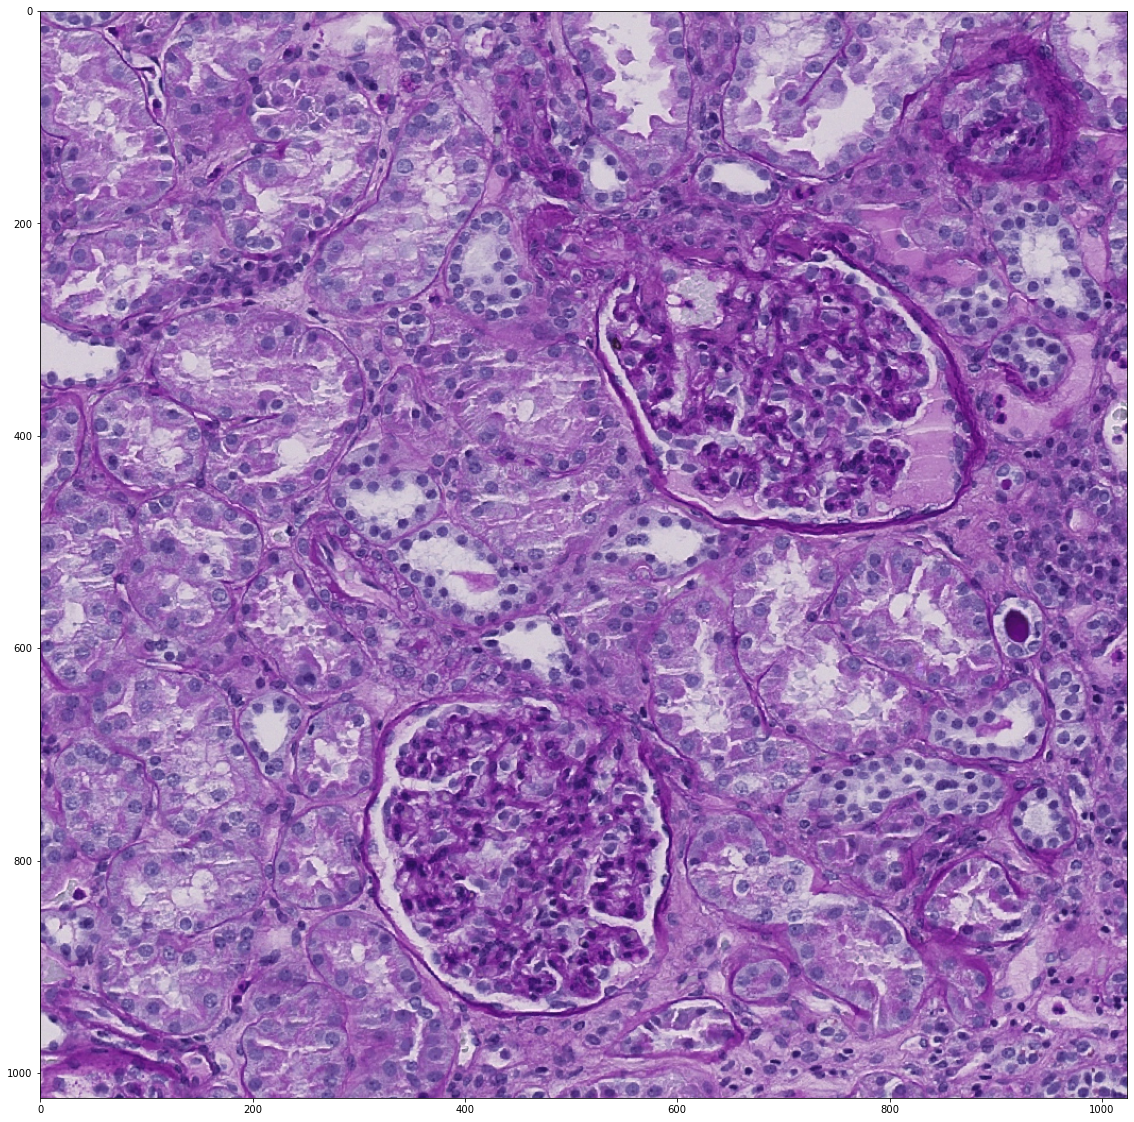

In [19]:
with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
    img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
    img = np.moveaxis(img, 0, -1)
    print(img.shape)
    crs = raster.crs

plt.figure(figsize = (20,20))
plt.imshow(img)
plt.show()


Writing to /home/jupyter/ds_cache/image_0


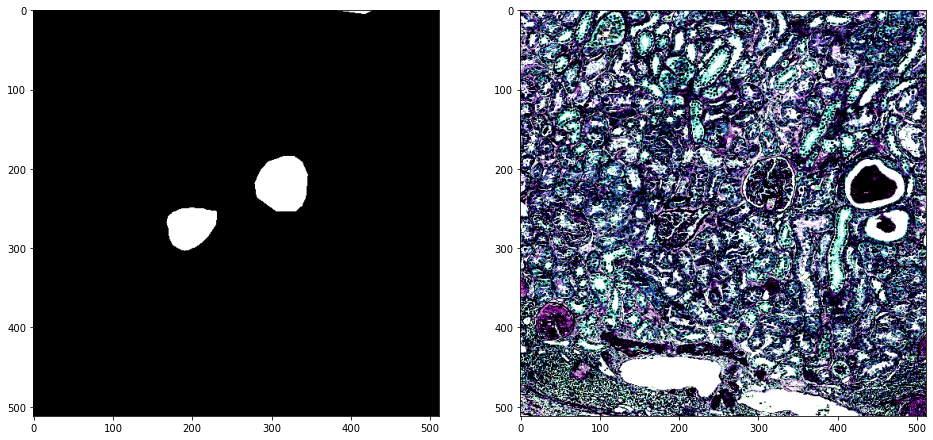

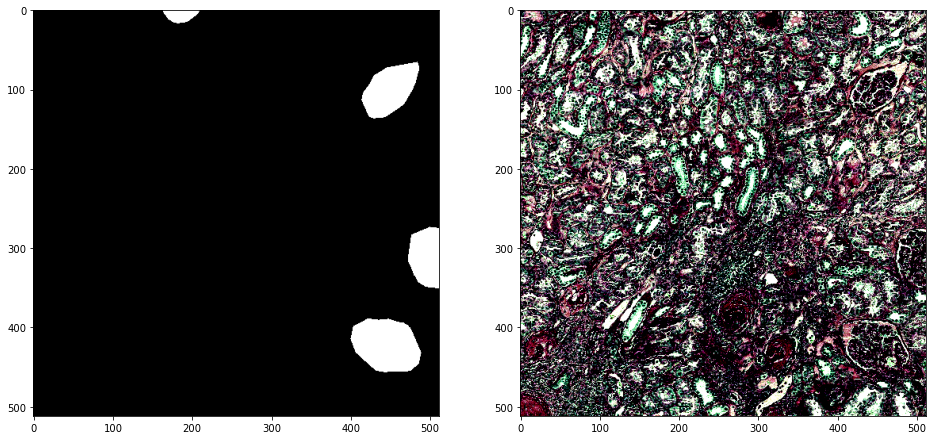

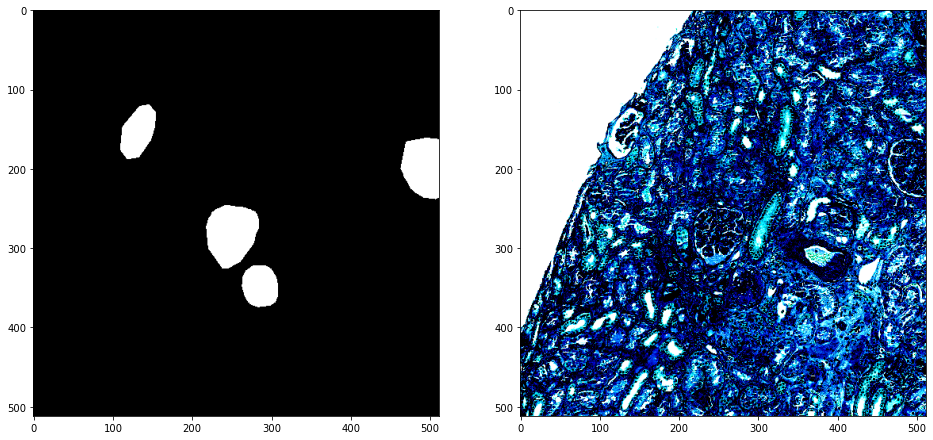

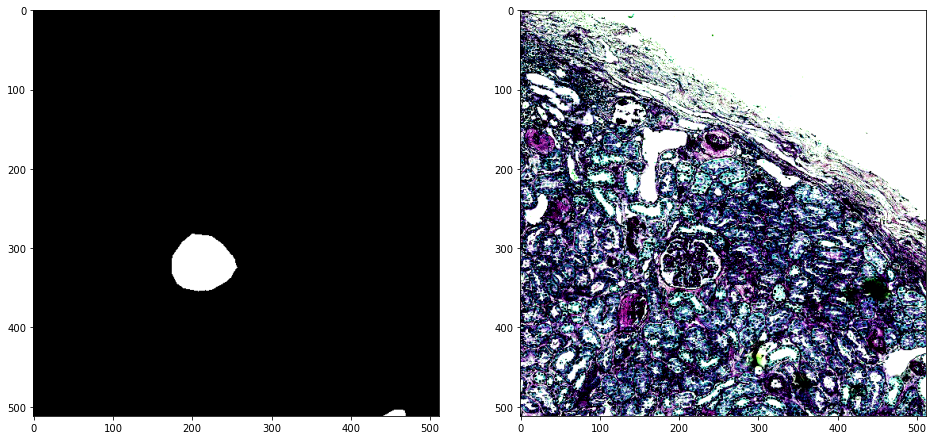

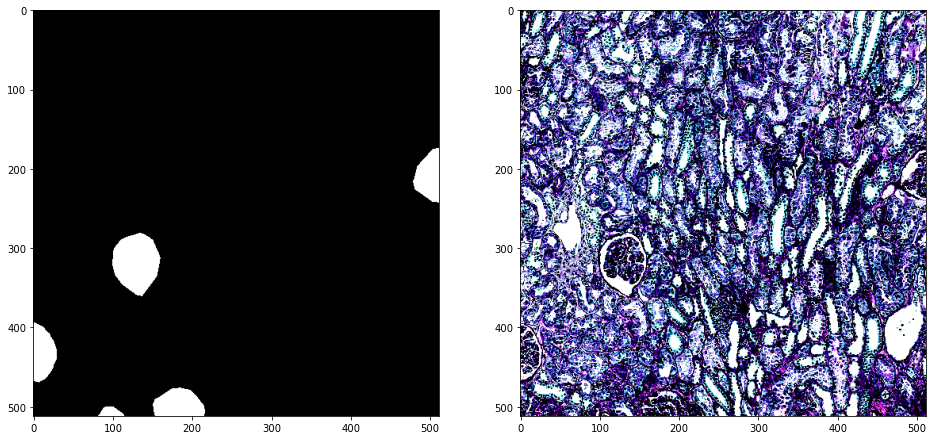

In [19]:
def display_mask_img(idx):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

display_mask_img(2)
display_mask_img(1)
display_mask_img(0)
display_mask_img(3)
display_mask_img(5)
display_mask_img(6)

In [20]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0]) # compile function with numba

#### Split

In [21]:
def create_split_on_index(img_index = 7):
    valid_idx, train_idx = [], []
    for i in range(len(ds)):
        if ds.slices[i][0] == img_index:
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return valid_idx, train_idx

#### Data loaders

In [22]:
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

### Model

In [24]:
ENCODER_NAME = 'efficientnet-b6'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = Unet(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [25]:
def get_model():
    model = HuBMAPModel()
    return model

### Training

In [26]:
LR = 1e-3
WD = 1e-3
BEST_MODEL = f'best_model_unet_512_{ENCODER_NAME}.pth'

In [27]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [28]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [29]:
dice_loss = smp.utils.losses.DiceLoss()

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [30]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [31]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [32]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu"):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        optim.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optim)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        train_loss.append(loss.item())
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [33]:
def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [46]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < iou_metric_mean:
            best_metric = iou_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        if early_stop_counter >= patience:
            print('Stopping early')
            break
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [47]:
# reset_mask_path()
# !mkdir {MASK_PATH}

In [48]:
EPOCHS = 20
PATIENCE = 7

In [49]:
def train_split(split):
    global model
    model = get_model()
    model.to(DEVICE)
    valid_idx, train_idx = create_split_on_index(split)
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [50]:
def train_split_and_move(split):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(split)
    !mv {BEST_MODEL} {split}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Writing to /home/jupyter/ds_cache/image_400
Writing to /home/jupyter/ds_cache/image_500
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_300
Writing to /home/jupyter/ds_cache/image_100
Train loss: 0.8920778583173883
Writing to /home/jupyter/ds_cache/image_600
Epoch 0 - valid loss: 0.8975103710378919
Saving model
Epoch 0 - val best loss 0.8975103710378919 dice metric (0.11049486297581877) iou metric (0.06586000283381768).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.8259733547903088
Epoch 1 - valid loss: 0.7854556398732322
Saving model
Epoch 1 - val best loss 0.7854556398732322 dice metric (0.3118683963215777) iou metric (0.19859179255685636).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.5679133330305962
Epoch 2 - valid loss: 0.3917885294982365
Saving model
Epoch 2 - val best loss 0.3917885294982365 dice metric (0.688799390935206) iou metric (0.630439983957097).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.21189708742376875
Epoch 3 - valid loss: 0.2125398346355983
Saving model
Epoch 3 - val best loss 0.2125398346355983 dice metric (0.7544043714380158) iou metric (0.70721185208383).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.13609961614216845
Epoch 4 - valid loss: 0.19388301457677568
Saving model
Epoch 4 - val best loss 0.19388301457677568 dice metric (0.7650463124404528) iou metric (0.7222385065997775).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.11915284803468887
Epoch 5 - valid loss: 0.18952653237751552
Saving model
Epoch 5 - val best loss 0.18952653237751552 dice metric (0.749069006415084) iou metric (0.7241145585366083).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.1046555074926925
Epoch 6 - valid loss: 0.18048773918833053
Saving model
Epoch 6 - val best loss 0.18048773918833053 dice metric (0.7727761833728957) iou metric (0.7372842218296294).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.10565613638864804
Epoch 7 - valid loss: 0.1833930696759905
Epoch 7 - val best loss 0.18048773918833053 dice metric (0.7766332765708545) iou metric (0.733428686867384).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0956402061736747
Epoch 8 - valid loss: 0.18215327177728927
Epoch 8 - val best loss 0.18048773918833053 dice metric (0.7678712102767479) iou metric (0.7340181342282905).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.09600340748486454
Epoch 9 - valid loss: 0.17583258662905013
Saving model
Epoch 9 - val best loss 0.17583258662905013 dice metric (0.7803258141170123) iou metric (0.7439924521207235).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0943936191193045
Epoch 10 - valid loss: 0.17301269514220102
Saving model
Epoch 10 - val best loss 0.17301269514220102 dice metric (0.7743029265464949) iou metric (0.7477023473909349).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.08803641469511267
Epoch 11 - valid loss: 0.1739752803530012
Epoch 11 - val best loss 0.17301269514220102 dice metric (0.7847507777956447) iou metric (0.7460935286214799).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.08449143252960623
Epoch 12 - valid loss: 0.17169801252228872
Saving model
Epoch 12 - val best loss 0.17169801252228872 dice metric (0.7841514488349536) iou metric (0.7495845811809237).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.08380095681099042
Epoch 13 - valid loss: 0.17715767451695033
Epoch 13 - val best loss 0.17169801252228872 dice metric (0.78302827168123) iou metric (0.7409012871230777).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.08185047482791012
Epoch 14 - valid loss: 0.17283973949296133
Epoch 14 - val best loss 0.17169801252228872 dice metric (0.7752090619012181) iou metric (0.748173764783938).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07792025069667868
Epoch 15 - valid loss: 0.17482290523392813
Epoch 15 - val best loss 0.17169801252228872 dice metric (0.7738565558767212) iou metric (0.7445246832812961).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07533463060039364
Epoch 16 - valid loss: 0.17258964691843307
Epoch 16 - val best loss 0.17169801252228872 dice metric (0.7773017086022135) iou metric (0.748029014904101).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07372203673401924
Epoch 17 - valid loss: 0.17296633975846426
Epoch 17 - val best loss 0.17169801252228872 dice metric (0.7793579836974719) iou metric (0.7472395471265764).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07251557830261858
Epoch 18 - valid loss: 0.17384481855801173
Epoch 18 - val best loss 0.17169801252228872 dice metric (0.7800769093779049) iou metric (0.7456954590013475).


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07249608513427107
Epoch 19 - valid loss: 0.17067781942231314
Saving model
Epoch 19 - val best loss 0.17067781942231314 dice metric (0.780216592862936) iou metric (0.7510349537746672).


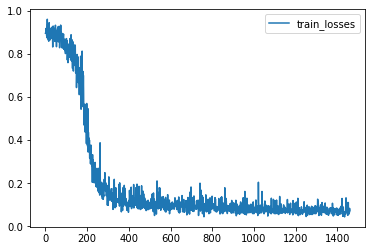

In [39]:
train_split_and_move(7)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.8834682404994965
Epoch 0 - valid loss: 0.8880542601857867
Saving model
Epoch 0 - val best loss 0.8880542601857867 dice metric (0.12584755143948964) iou metric (0.08016102494938034).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.784846817702055
Epoch 1 - valid loss: 0.751063849244799
Saving model
Epoch 1 - val best loss 0.751063849244799 dice metric (0.4100061484745571) iou metric (0.3035702939544405).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.4879762947559357
Epoch 2 - valid loss: 0.3009884016854422
Saving model
Epoch 2 - val best loss 0.3009884016854422 dice metric (0.799185037612915) iou metric (0.7250431776046753).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.19589984714984893
Epoch 3 - valid loss: 0.13075017077582224
Saving model
Epoch 3 - val best loss 0.13075017077582224 dice metric (0.8549422451428005) iou metric (0.7947696873119899).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.13305961936712266
Epoch 4 - valid loss: 0.10903397628239223
Saving model
Epoch 4 - val best loss 0.10903397628239223 dice metric (0.8772112812314715) iou metric (0.8161457862172808).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.11812403798103333
Epoch 5 - valid loss: 0.10888525417872838
Epoch 5 - val best loss 0.10888525417872838 dice metric (0.86750876052039) iou metric (0.8094470841544015).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.11015871837735176
Epoch 6 - valid loss: 0.11422345467976161
Epoch 6 - val best loss 0.10888525417872838 dice metric (0.8475441932678223) iou metric (0.7993180240903582).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.10368797779083253
Epoch 7 - valid loss: 0.08786427974700928
Saving model
Epoch 7 - val best loss 0.08786427974700928 dice metric (0.8864177720887321) iou metric (0.8392181481633868).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.09640978425741195
Epoch 8 - valid loss: 0.08150799785341535
Saving model
Epoch 8 - val best loss 0.08150799785341535 dice metric (0.8913867133004325) iou metric (0.8514423796108791).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.09613304734230041
Epoch 9 - valid loss: 0.07833471468516759
Saving model
Epoch 9 - val best loss 0.07833471468516759 dice metric (0.8985525114195687) iou metric (0.8563864827156067).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.09290412738919258
Epoch 10 - valid loss: 0.08228265387671334
Epoch 10 - val best loss 0.07833471468516759 dice metric (0.9020241584096637) iou metric (0.8500293919018337).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.08832311630249023
Epoch 11 - valid loss: 0.08348069020680018
Epoch 11 - val best loss 0.07833471468516759 dice metric (0.8870565210069928) iou metric (0.8469294479915074).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.08769034296274185
Epoch 12 - valid loss: 0.08652976581028529
Epoch 12 - val best loss 0.07833471468516759 dice metric (0.8826679161616734) iou metric (0.8427037341254098).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.08373420313000679
Epoch 13 - valid loss: 0.08596977165767125
Epoch 13 - val best loss 0.07833471468516759 dice metric (0.8876346094267709) iou metric (0.8431747215134757).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.08278344348073005
Epoch 14 - valid loss: 0.07951256207057408
Epoch 14 - val best loss 0.07833471468516759 dice metric (0.8961550763675145) iou metric (0.853171706199646).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.0789386734366417
Epoch 15 - valid loss: 0.07935728345598493
Epoch 15 - val best loss 0.07833471468516759 dice metric (0.8971347979136876) iou metric (0.8537506290844509).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.07509442642331124
Epoch 16 - valid loss: 0.08352661984307426
Epoch 16 - val best loss 0.07833471468516759 dice metric (0.8901993121419635) iou metric (0.8464503969464984).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.07416140437126159
Epoch 17 - valid loss: 0.08294384820120675
Epoch 17 - val best loss 0.07833471468516759 dice metric (0.889181877885546) iou metric (0.8478993347712925).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.07414959371089935
Epoch 18 - valid loss: 0.08099265609468732
Epoch 18 - val best loss 0.07833471468516759 dice metric (0.8959681051118034) iou metric (0.8507035374641418).


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.07346193566918373
Epoch 19 - valid loss: 0.08139031273978097
Epoch 19 - val best loss 0.07833471468516759 dice metric (0.8918031879833767) iou metric (0.8506409185273307).


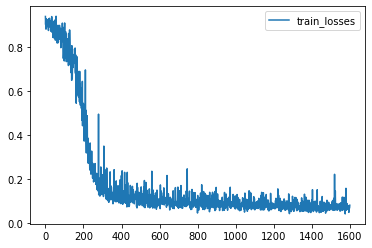

In [42]:
train_split_and_move(0)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.884064116855947
Epoch 0 - valid loss: 0.9011383175849914
Saving model
Epoch 0 - val best loss 0.9011383175849914 dice metric (0.09963993728160858) iou metric (0.06041461899876595).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.8035036536251626
Epoch 1 - valid loss: 0.846905791759491
Saving model
Epoch 1 - val best loss 0.846905791759491 dice metric (0.17261127531528472) iou metric (0.10976628363132476).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.516893282169249
Epoch 2 - valid loss: 0.4183459758758545
Saving model
Epoch 2 - val best loss 0.4183459758758545 dice metric (0.6580189824104309) iou metric (0.5999890327453613).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.1915280513647126
Epoch 3 - valid loss: 0.20792269706726074
Saving model
Epoch 3 - val best loss 0.20792269706726074 dice metric (0.7753615021705628) iou metric (0.6796401739120483).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.12528241625646266
Epoch 4 - valid loss: 0.1448146104812622
Saving model
Epoch 4 - val best loss 0.1448146104812622 dice metric (0.822790014743805) iou metric (0.7586243987083435).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.11092641876965034
Epoch 5 - valid loss: 0.13151098489761354
Saving model
Epoch 5 - val best loss 0.13151098489761354 dice metric (0.8576217532157898) iou metric (0.7775252103805542).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.10432282453630029
Epoch 6 - valid loss: 0.1464185357093811
Epoch 6 - val best loss 0.13151098489761354 dice metric (0.8206149935722351) iou metric (0.7483055830001831).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.10210674565012862
Epoch 7 - valid loss: 0.11921545267105102
Saving model
Epoch 7 - val best loss 0.11921545267105102 dice metric (0.8429847002029419) iou metric (0.7892298817634582).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.1054964988696866
Epoch 8 - valid loss: 0.18238316774368285
Epoch 8 - val best loss 0.11921545267105102 dice metric (0.755048394203186) iou metric (0.6925751805305481).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.09437773576596888
Epoch 9 - valid loss: 0.15200870037078856
Epoch 9 - val best loss 0.11921545267105102 dice metric (0.8146304368972779) iou metric (0.7403846502304077).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.09159672260284424
Epoch 10 - valid loss: 0.17509691715240477
Epoch 10 - val best loss 0.11921545267105102 dice metric (0.805335283279419) iou metric (0.704310393333435).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.0871359291600018
Epoch 11 - valid loss: 0.16417839527130126
Epoch 11 - val best loss 0.11921545267105102 dice metric (0.7943434000015259) iou metric (0.7196346402168274).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.08719334733195422
Epoch 12 - valid loss: 0.15958744287490845
Epoch 12 - val best loss 0.11921545267105102 dice metric (0.7616404175758362) iou metric (0.7273802518844604).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.08445580630767636
Epoch 13 - valid loss: 0.1387810230255127
Epoch 13 - val best loss 0.11921545267105102 dice metric (0.7763744115829467) iou metric (0.75864577293396).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.08213751490523176
Epoch 14 - valid loss: 0.12958821058273315
Epoch 14 - val best loss 0.11921545267105102 dice metric (0.8499866843223571) iou metric (0.7715490818023681).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.07894713049981653
Epoch 15 - valid loss: 0.13511332273483276
Epoch 15 - val best loss 0.11921545267105102 dice metric (0.8409930467605591) iou metric (0.7629544615745545).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.0752188636035454
Epoch 16 - valid loss: 0.13101249933242798
Epoch 16 - val best loss 0.11921545267105102 dice metric (0.8257631540298462) iou metric (0.7694127440452576).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.07444939308050202
Epoch 17 - valid loss: 0.12641342878341674
Epoch 17 - val best loss 0.11921545267105102 dice metric (0.8354438304901123) iou metric (0.7764365792274475).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.07371689342870945
Epoch 18 - valid loss: 0.1202315092086792
Epoch 18 - val best loss 0.11921545267105102 dice metric (0.839215624332428) iou metric (0.7863772630691528).


  0%|          | 0/82 [00:00<?, ?it/s]

Train loss: 0.073891752376789
Epoch 19 - valid loss: 0.13317198753356935
Epoch 19 - val best loss 0.11921545267105102 dice metric (0.8541486859321594) iou metric (0.7661500930786133).


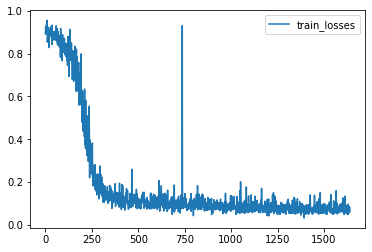

In [41]:
train_split_and_move(1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.8801834062791206
Epoch 0 - valid loss: 0.8491771976153056
Saving model
Epoch 0 - val best loss 0.8491771976153056 dice metric (0.1723560447494189) iou metric (0.12869824518760045).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.803693134180257
Epoch 1 - valid loss: 0.6952577273050944
Saving model
Epoch 1 - val best loss 0.6952577273050944 dice metric (0.48221987585226694) iou metric (0.3796975056330363).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.554025219359868
Epoch 2 - valid loss: 0.30732640425364177
Saving model
Epoch 2 - val best loss 0.30732640425364177 dice metric (0.7748581727345785) iou metric (0.7356204708417257).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.22250555266796704
Epoch 3 - valid loss: 0.1504642407099406
Saving model
Epoch 3 - val best loss 0.1504642407099406 dice metric (0.792081340154012) iou metric (0.7681987722714742).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.14846773466593782
Epoch 4 - valid loss: 0.10809946457544962
Saving model
Epoch 4 - val best loss 0.10809946457544962 dice metric (0.8337820370992025) iou metric (0.815021284421285).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.12189313979216025
Epoch 5 - valid loss: 0.09502431551615396
Saving model
Epoch 5 - val best loss 0.09502431551615396 dice metric (0.8454497257868449) iou metric (0.8310610016187032).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.11596143161746818
Epoch 6 - valid loss: 0.09443174997965495
Saving model
Epoch 6 - val best loss 0.09443174997965495 dice metric (0.8504253069559733) iou metric (0.8312333067258199).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.11055566391474764
Epoch 7 - valid loss: 0.08235939343770345
Saving model
Epoch 7 - val best loss 0.08235939343770345 dice metric (0.8630937655766805) iou metric (0.8512975255648295).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.1042824580635823
Epoch 8 - valid loss: 0.08125664790471394
Saving model
Epoch 8 - val best loss 0.08125664790471394 dice metric (0.8576010306676228) iou metric (0.8521192669868469).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.10285942319413306
Epoch 9 - valid loss: 0.08506039381027222
Epoch 9 - val best loss 0.08125664790471394 dice metric (0.8638800223668416) iou metric (0.8458086967468261).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.09777927986333068
Epoch 10 - valid loss: 0.08758885463078817
Epoch 10 - val best loss 0.08125664790471394 dice metric (0.8620719909667969) iou metric (0.8414244055747986).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.09402766026241678
Epoch 11 - valid loss: 0.08649631738662719
Epoch 11 - val best loss 0.08125664790471394 dice metric (0.8496633211771647) iou metric (0.8425940910975138).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.09269164901384165
Epoch 12 - valid loss: 0.08297096888224284
Epoch 12 - val best loss 0.08125664790471394 dice metric (0.8635929902394612) iou metric (0.8487146059672038).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.086430763694602
Epoch 13 - valid loss: 0.07755428949991862
Saving model
Epoch 13 - val best loss 0.07755428949991862 dice metric (0.8696429491043091) iou metric (0.8579729398091634).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.08627613245601386
Epoch 14 - valid loss: 0.08489800691604614
Epoch 14 - val best loss 0.07755428949991862 dice metric (0.8587220589319865) iou metric (0.8456009030342102).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.08449446147596332
Epoch 15 - valid loss: 0.07898075580596924
Epoch 15 - val best loss 0.07755428949991862 dice metric (0.86751815478007) iou metric (0.8550326585769653).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.08022418744127516
Epoch 16 - valid loss: 0.078854767481486
Epoch 16 - val best loss 0.07755428949991862 dice metric (0.8691041707992554) iou metric (0.8553893367449442).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.08017283762005013
Epoch 17 - valid loss: 0.08012100060780843
Epoch 17 - val best loss 0.07755428949991862 dice metric (0.8666594862937927) iou metric (0.853564993540446).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.07748910071144641
Epoch 18 - valid loss: 0.07989424467086792
Epoch 18 - val best loss 0.07755428949991862 dice metric (0.8674363533655802) iou metric (0.8538731495539348).


  0%|          | 0/71 [00:00<?, ?it/s]

Train loss: 0.07751957379596335
Epoch 19 - valid loss: 0.07819608449935914
Epoch 19 - val best loss 0.07755428949991862 dice metric (0.8638376712799072) iou metric (0.8563679814338684).
Stopping early


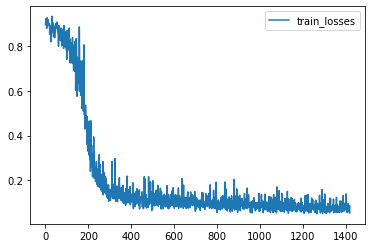

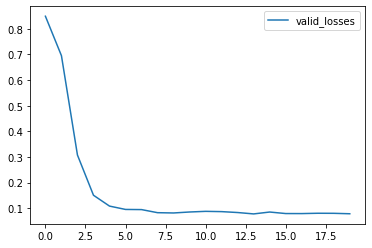

In [51]:
train_split_and_move(2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.8865601752377763
Epoch 0 - valid loss: 0.886400043964386
Saving model
Epoch 0 - val best loss 0.886400043964386 dice metric (0.12196606291191918) iou metric (0.07838618116719383).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.8309619072117383
Epoch 1 - valid loss: 0.7769554427691868
Saving model
Epoch 1 - val best loss 0.7769554427691868 dice metric (0.4683183346475874) iou metric (0.3787472950560706).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.6261552911770495
Epoch 2 - valid loss: 0.35680730853761944
Saving model
Epoch 2 - val best loss 0.35680730853761944 dice metric (0.7964090619768415) iou metric (0.7433440600122724).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.25261617838581907
Epoch 3 - valid loss: 0.12348507131849017
Saving model
Epoch 3 - val best loss 0.12348507131849017 dice metric (0.8733212692396981) iou metric (0.8301660418510437).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.14663083794750745
Epoch 4 - valid loss: 0.08912507125309535
Saving model
Epoch 4 - val best loss 0.08912507125309535 dice metric (0.8847272396087646) iou metric (0.8496841021946498).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.12160820447945897
Epoch 5 - valid loss: 0.06804760013307844
Saving model
Epoch 5 - val best loss 0.06804760013307844 dice metric (0.9006935698645455) iou metric (0.8788008945328849).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.10689506651479987
Epoch 6 - valid loss: 0.07048990896769933
Epoch 6 - val best loss 0.06804760013307844 dice metric (0.8949858716556004) iou metric (0.8728928310530526).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.10596797737894179
Epoch 7 - valid loss: 0.06749440090996879
Epoch 7 - val best loss 0.06749440090996879 dice metric (0.895428580897195) iou metric (0.8773544175284249).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.09911821386482142
Epoch 8 - valid loss: 0.059518865176609585
Saving model
Epoch 8 - val best loss 0.059518865176609585 dice metric (0.9169122491564069) iou metric (0.8898017917360578).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.09838253108760979
Epoch 9 - valid loss: 0.06451950754438128
Epoch 9 - val best loss 0.059518865176609585 dice metric (0.9133368389947074) iou metric (0.8833216939653669).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.09595006779779362
Epoch 10 - valid loss: 0.06176920448030744
Epoch 10 - val best loss 0.059518865176609585 dice metric (0.9048456634793963) iou metric (0.8851958683558873).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.08919836524166638
Epoch 11 - valid loss: 0.06322825806481498
Epoch 11 - val best loss 0.059518865176609585 dice metric (0.8996897680418832) iou metric (0.8820371542658124).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.08667708952215654
Epoch 12 - valid loss: 0.06268949168069023
Epoch 12 - val best loss 0.059518865176609585 dice metric (0.9115700125694275) iou metric (0.884531285081591).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.0829923507533496
Epoch 13 - valid loss: 0.06289300748280116
Epoch 13 - val best loss 0.059518865176609585 dice metric (0.9096072827066694) iou metric (0.883389915738787).


  0%|          | 0/79 [00:00<?, ?it/s]

Train loss: 0.08290600550325611
Epoch 14 - valid loss: 0.0610544000353132
Epoch 14 - val best loss 0.059518865176609585 dice metric (0.9139116065842765) iou metric (0.8869483981813703).
Stopping early


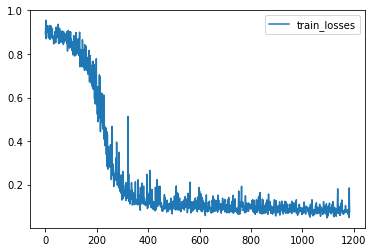

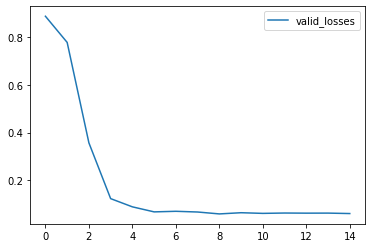

In [52]:
train_split_and_move(3)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.8813305012385051
Epoch 0 - valid loss: 0.8623912433783213
Saving model
Epoch 0 - val best loss 0.8623912433783213 dice metric (0.15308611762399474) iou metric (0.10285769783270855).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.8068076475461324
Epoch 1 - valid loss: 0.7506834318240484
Saving model
Epoch 1 - val best loss 0.7506834318240484 dice metric (0.3451240765862167) iou metric (0.23586662680221102).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.5511937403678894
Epoch 2 - valid loss: 0.4051346629858017
Saving model
Epoch 2 - val best loss 0.4051346629858017 dice metric (0.6947805763556971) iou metric (0.6302758008269637).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.2230379033088684
Epoch 3 - valid loss: 0.25710127751032513
Saving model
Epoch 3 - val best loss 0.25710127751032513 dice metric (0.7196312289840231) iou metric (0.652261242273268).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.13767171621322633
Epoch 4 - valid loss: 0.22210362553596497
Saving model
Epoch 4 - val best loss 0.22210362553596497 dice metric (0.7392466556436071) iou metric (0.6861955920883188).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.11441514253616333
Epoch 5 - valid loss: 0.21331875522931418
Saving model
Epoch 5 - val best loss 0.21331875522931418 dice metric (0.7493314124682607) iou metric (0.6946089069075594).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.10598521947860717
Epoch 6 - valid loss: 0.21562068661053976
Epoch 6 - val best loss 0.21331875522931418 dice metric (0.7459506843709581) iou metric (0.6902820815661806).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.09924904743830364
Epoch 7 - valid loss: 0.21744053065776825
Epoch 7 - val best loss 0.21331875522931418 dice metric (0.7357625952766588) iou metric (0.6857151190467844).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.0939633854230245
Epoch 8 - valid loss: 0.23611610134442648
Epoch 8 - val best loss 0.21331875522931418 dice metric (0.7111185910119578) iou metric (0.6571554293254646).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.0918899941444397
Epoch 9 - valid loss: 0.20741883416970572
Saving model
Epoch 9 - val best loss 0.20741883416970572 dice metric (0.7505860419478267) iou metric (0.6997388750342696).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.09113635142644247
Epoch 10 - valid loss: 0.20925185084342957
Epoch 10 - val best loss 0.20741883416970572 dice metric (0.757816671471422) iou metric (0.6960033377039601).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.0868332862854004
Epoch 11 - valid loss: 0.20250281691551208
Saving model
Epoch 11 - val best loss 0.20250281691551208 dice metric (0.7595012461824808) iou metric (0.7069029559718102).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.08052821397781372
Epoch 12 - valid loss: 0.20014649629592896
Saving model
Epoch 12 - val best loss 0.20014649629592896 dice metric (0.7627118925423323) iou metric (0.7103119244206008).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.08285430510838826
Epoch 13 - valid loss: 0.20669071873029074
Epoch 13 - val best loss 0.20014649629592896 dice metric (0.7381408404714117) iou metric (0.7019031892248163).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.07561689297358196
Epoch 14 - valid loss: 0.21101959546407065
Epoch 14 - val best loss 0.20014649629592896 dice metric (0.744295109451438) iou metric (0.6940111120569874).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.07524858554204306
Epoch 15 - valid loss: 0.21204330523808798
Epoch 15 - val best loss 0.20014649629592896 dice metric (0.7425582152015219) iou metric (0.6925388127593367).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.07271143515904745
Epoch 16 - valid loss: 0.20611240963141123
Epoch 16 - val best loss 0.20014649629592896 dice metric (0.7553665083056936) iou metric (0.7014386802939742).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.06979344924290976
Epoch 17 - valid loss: 0.20588384568691254
Epoch 17 - val best loss 0.20014649629592896 dice metric (0.7534349601871023) iou metric (0.7022262861359287).


  0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.06964956601460774
Epoch 18 - valid loss: 0.2101017584403356
Epoch 18 - val best loss 0.20014649629592896 dice metric (0.7527251384065797) iou metric (0.6954066803085972).
Stopping early


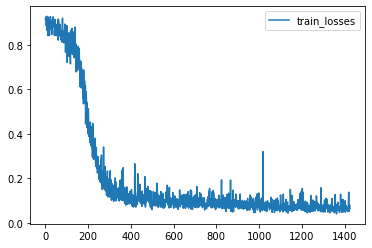

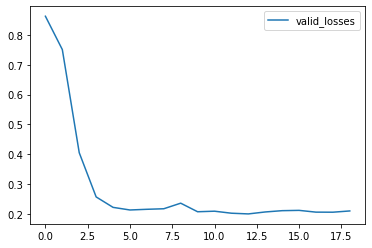

In [53]:
train_split_and_move(4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.8862840849341769
Epoch 0 - valid loss: 0.8570696324110031
Saving model
Epoch 0 - val best loss 0.8570696324110031 dice metric (0.13603879883885384) iou metric (0.0922121413052082).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.8287946157383196
Epoch 1 - valid loss: 0.7755463898181916
Saving model
Epoch 1 - val best loss 0.7755463898181916 dice metric (0.2868378903716803) iou metric (0.2119579341262579).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.6524848739306132
Epoch 2 - valid loss: 0.4523100256919861
Saving model
Epoch 2 - val best loss 0.4523100256919861 dice metric (0.6518942415714264) iou metric (0.5725111097097397).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.27156520612312085
Epoch 3 - valid loss: 0.2617292821407318
Saving model
Epoch 3 - val best loss 0.2617292821407318 dice metric (0.6979883596301079) iou metric (0.628561420738697).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.1338052207773382
Epoch 4 - valid loss: 0.17647024095058442
Saving model
Epoch 4 - val best loss 0.17647024095058442 dice metric (0.7679323613643646) iou metric (0.7133029639720917).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.10930022236072656
Epoch 5 - valid loss: 0.1450977325439453
Saving model
Epoch 5 - val best loss 0.1450977325439453 dice metric (0.7911091327667237) iou metric (0.7518589317798614).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.10312315821647644
Epoch 6 - valid loss: 0.14459645748138428
Epoch 6 - val best loss 0.14459645748138428 dice metric (0.7785229742527008) iou metric (0.7502392917871475).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.09490247296564507
Epoch 7 - valid loss: 0.14693202078342438
Epoch 7 - val best loss 0.14459645748138428 dice metric (0.7802545845508575) iou metric (0.7470015227794647).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.08702820991024826
Epoch 8 - valid loss: 0.1428642302751541
Saving model
Epoch 8 - val best loss 0.1428642302751541 dice metric (0.7943714812397957) iou metric (0.753692427277565).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.08881098122307748
Epoch 9 - valid loss: 0.14141686558723449
Saving model
Epoch 9 - val best loss 0.14141686558723449 dice metric (0.7748997896909714) iou metric (0.7537801593542099).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.08178553256121548
Epoch 10 - valid loss: 0.13907243311405182
Saving model
Epoch 10 - val best loss 0.13907243311405182 dice metric (0.7833084434270858) iou metric (0.7568377673625946).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.07941133506370313
Epoch 11 - valid loss: 0.144203782081604
Epoch 11 - val best loss 0.13907243311405182 dice metric (0.7777383387088775) iou metric (0.75017269551754).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.07799586021538937
Epoch 12 - valid loss: 0.13914229571819306
Saving model
Epoch 12 - val best loss 0.13907243311405182 dice metric (0.8021870046854019) iou metric (0.7574724137783051).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.07349222537243005
Epoch 13 - valid loss: 0.13718572556972503
Saving model
Epoch 13 - val best loss 0.13718572556972503 dice metric (0.7897001087665558) iou metric (0.7598618000745774).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.07283418648170703
Epoch 14 - valid loss: 0.1403227388858795
Epoch 14 - val best loss 0.13718572556972503 dice metric (0.7959905862808228) iou metric (0.756109955906868).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.06986132896307742
Epoch 15 - valid loss: 0.13469546437263488
Saving model
Epoch 15 - val best loss 0.13469546437263488 dice metric (0.8083528965711594) iou metric (0.7638975113630295).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.06834360866835623
Epoch 16 - valid loss: 0.13971177041530608
Epoch 16 - val best loss 0.13469546437263488 dice metric (0.803593099117279) iou metric (0.7564578950405121).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.06718602776527405
Epoch 17 - valid loss: 0.13346465826034545
Saving model
Epoch 17 - val best loss 0.13346465826034545 dice metric (0.8046686798334122) iou metric (0.7657041847705841).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.06548267151370193
Epoch 18 - valid loss: 0.135869163274765
Epoch 18 - val best loss 0.13346465826034545 dice metric (0.8071898221969604) iou metric (0.7619838327169418).


  0%|          | 0/66 [00:00<?, ?it/s]

Train loss: 0.0662915516983379
Epoch 19 - valid loss: 0.13890230059623718
Epoch 19 - val best loss 0.13346465826034545 dice metric (0.8042234241962433) iou metric (0.758224555850029).


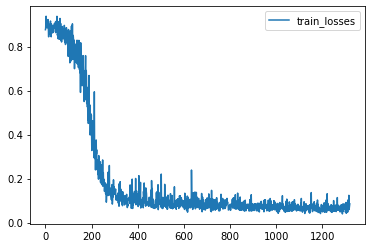

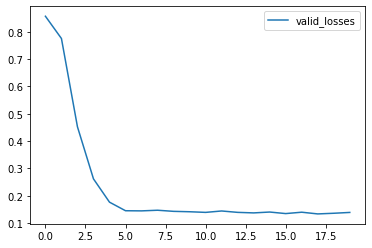

In [54]:
train_split_and_move(5)

In [ ]:
train_split_and_move(6)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.8930180289528586
Epoch 0 - valid loss: 0.8642315599653456
Saving model
Epoch 0 - val best loss 0.8642315599653456 dice metric (0.1298101701670223) iou metric (0.07754422682854864).


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.8529417832176407
Epoch 1 - valid loss: 0.7766750918494331
Saving model
Epoch 1 - val best loss 0.7766750918494331 dice metric (0.4199160867267185) iou metric (0.33292148676183486).


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.6896149283879763
Epoch 2 - valid loss: 0.4811306794484456
Saving model
Epoch 2 - val best loss 0.4811306794484456 dice metric (0.6897296011447906) iou metric (0.6562062435679965).


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.28527647643894344
Epoch 3 - valid loss: 0.17565278874503243
Saving model
Epoch 3 - val best loss 0.17565278874503243 dice metric (0.7778688470522562) iou metric (0.7471902370452881).


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.1424211310101794
Epoch 4 - valid loss: 0.1288424531618754
Saving model
Epoch 4 - val best loss 0.1288424531618754 dice metric (0.8017108771536086) iou metric (0.7800344427426656).


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.1173179792119311
Epoch 5 - valid loss: 0.12107291486528185
Saving model
Epoch 5 - val best loss 0.12107291486528185 dice metric (0.8055989940961202) iou metric (0.7888539301024543).


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.10835560807934055
Epoch 6 - valid loss: 0.13419548670450845
Epoch 6 - val best loss 0.12107291486528185 dice metric (0.7604828344451057) iou metric (0.7651462091339959).


  0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
!mv *.pth models